In [1]:
import pandas as pd
df = pd.read_csv("merged_Interp_flat.csv", low_memory=False)
print("Dataset loaded:", df.shape)


Dataset loaded: (8852, 4010)


In [2]:
from sklearn.impute import SimpleImputer

selected_features = [f'q_interp_{i}' for i in range(100)] + [f'i_interp_{i}' for i in range(100)] + ['cycle_index']
X = df[selected_features].copy()
y = df["soh"]

imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

print("Features ready for training:", X_imputed.shape)


Features ready for training: (8852, 201)


In [3]:
from sklearn.model_selection import BaseCrossValidator

class BatteryWiseSplit(BaseCrossValidator):
    def __init__(self, n_splits=5, random_state=None, column_group='source'):
        self.n_splits = n_splits
        self.random_state = random_state
        self.column_group = column_group

    def split(self, X, y=None, groups=None):
        df_ = X.copy()
        df_['cell_id'] = df['cell_id']
        df_['source'] = df['source']
        import numpy as np
        rng = np.random.RandomState(self.random_state)
        unique_batteries = df_[['cell_id', 'source']].drop_duplicates()
        batteries_by_source = unique_batteries.groupby('source')['cell_id'].apply(list)

        folds = [[] for _ in range(self.n_splits)]
        for source, battery_list in batteries_by_source.items():
            rng.shuffle(battery_list)
            for i, battery_id in enumerate(battery_list):
                folds[i % self.n_splits].append(battery_id)

        for i in range(self.n_splits):
            val_batteries = set(folds[i])
            train_batteries = set(unique_batteries['cell_id']) - val_batteries
            train_idx = df_[df_['cell_id'].isin(train_batteries)].index
            val_idx = df_[df_['cell_id'].isin(val_batteries)].index
            yield train_idx, val_idx

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import numpy as np

model = RandomForestRegressor(n_estimators=100, random_state=42)
splitter = BatteryWiseSplit(n_splits=5, random_state=42)

rmse_list, mae_list, r2_list, inference_times = [], [], [], []

for fold, (train_idx, val_idx) in enumerate(splitter.split(df)):
    X_train, X_val = X_imputed[train_idx], X_imputed[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(X_train, y_train)
    start_time = time.time()
    y_pred = model.predict(X_val)
    inference_time = time.time() - start_time

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    inference_times.append(inference_time)

    print(f"Fold {fold+1} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


Fold 1 → RMSE: 0.0397, MAE: 0.0134, R²: 0.9724
Fold 2 → RMSE: 0.0381, MAE: 0.0116, R²: 0.9575
Fold 3 → RMSE: 0.0275, MAE: 0.0077, R²: 0.9835
Fold 4 → RMSE: 0.0279, MAE: 0.0082, R²: 0.9793
Fold 5 → RMSE: 0.0353, MAE: 0.0119, R²: 0.9826


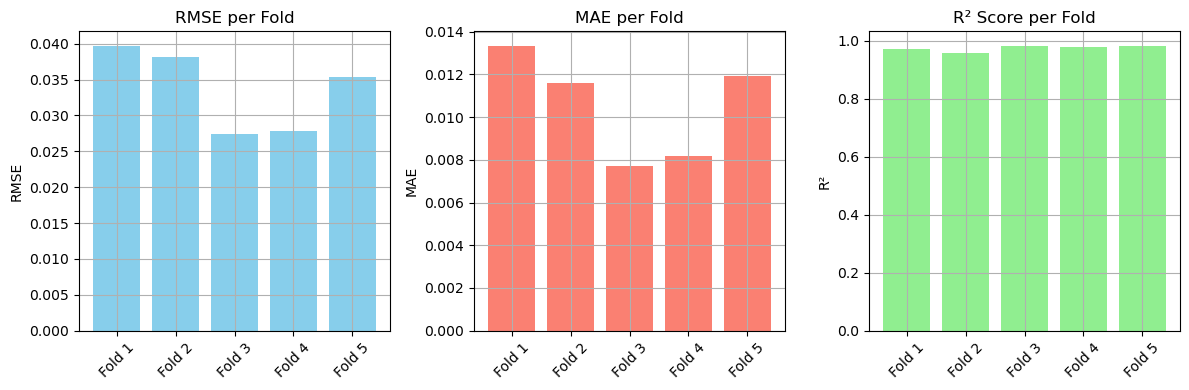

In [5]:
import matplotlib.pyplot as plt

# Label untuk setiap fold
folds = [f"Fold {i+1}" for i in range(5)]

# Bar Plot untuk RMSE, MAE, dan R²
plt.figure(figsize=(12, 4))

# RMSE
plt.subplot(1, 3, 1)
plt.bar(folds, rmse_list, color='skyblue')
plt.title("RMSE per Fold")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.grid(True)

# MAE
plt.subplot(1, 3, 2)
plt.bar(folds, mae_list, color='salmon')
plt.title("MAE per Fold")
plt.ylabel("MAE")
plt.xticks(rotation=45)
plt.grid(True)

# R²
plt.subplot(1, 3, 3)
plt.bar(folds, r2_list, color='lightgreen')
plt.title("R² Score per Fold")
plt.ylabel("R²")
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()


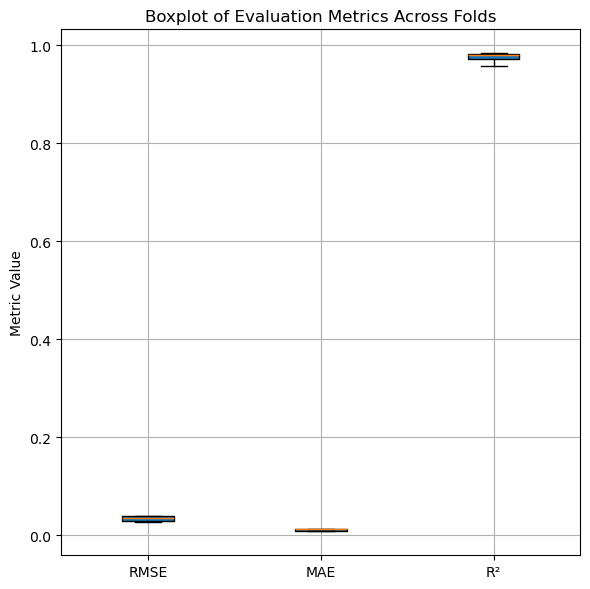

In [6]:
# Boxplot untuk RMSE, MAE, dan R² dalam satu gambar
plt.figure(figsize=(6, 6))
plt.boxplot(
    [rmse_list, mae_list, r2_list],
    tick_labels=["RMSE", "MAE", "R²"],  # fix warning: renamed 'labels' → 'tick_labels'
    patch_artist=True
)
plt.title("Boxplot of Evaluation Metrics Across Folds")
plt.ylabel("Metric Value")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
plt.savefig("metrics_boxplot_v3.png", dpi=300)


<Figure size 640x480 with 0 Axes>

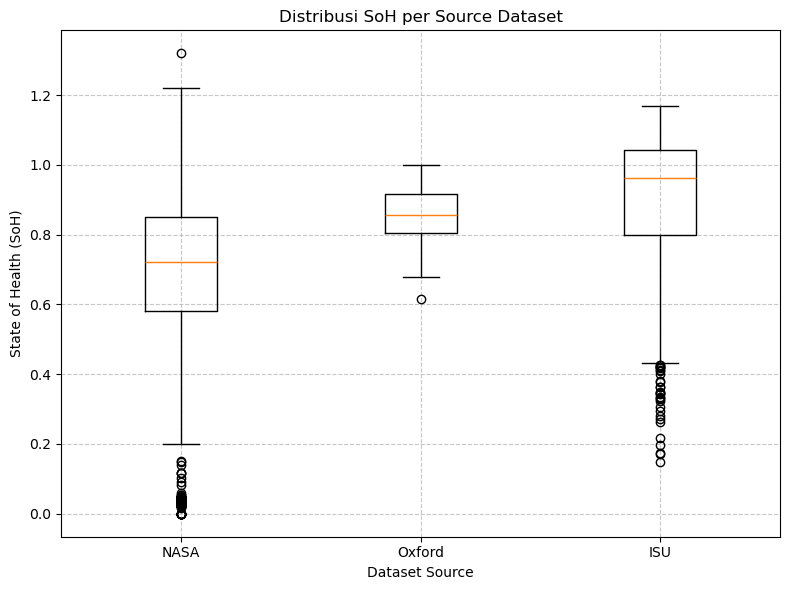

In [22]:
import matplotlib.pyplot as plt

# Take SoH from every source
soh_nasa = df[df['source'] == 'nasa']['soh']
soh_oxford = df[df['source'] == 'oxford']['soh']
soh_isu = df[df['source'] == 'isu']['soh']

# Plot boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(
    [soh_nasa, soh_oxford, soh_isu],
    tick_labels=["NASA", "Oxford", "ISU"]
)
plt.title("Distribusi SoH per Source Dataset")
plt.ylabel("State of Health (SoH)")
plt.xlabel("Dataset Source")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("soh_distribution_per_source_matplotlib.png", dpi=300)
plt.show()


In [9]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import numpy as np

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

splitter = BatteryWiseSplit(n_splits=5, random_state=42)
grid = list(ParameterGrid(param_grid))

best_score = float('inf')
best_model = None
best_params = None

for params in grid:
    model = RandomForestRegressor(random_state=42, **params)
    fold_scores = []

    for train_idx, val_idx in splitter.split(df):
        X_train, X_val = X_imputed[train_idx], X_imputed[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        fold_scores.append(rmse)

    avg_rmse = np.mean(fold_scores)
    print(f"Params: {params} → Avg RMSE: {avg_rmse:.4f}")

    if avg_rmse < best_score:
        best_score = avg_rmse
        best_model = model
        best_params = params

# Simpan model terbaik
import joblib
joblib.dump(best_model, "RF_tuned_v3.pkl")
print("\nBest Params:", best_params)



Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100} → Avg RMSE: 0.0337
Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200} → Avg RMSE: 0.0335
Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100} → Avg RMSE: 0.0339
Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200} → Avg RMSE: 0.0336
Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100} → Avg RMSE: 0.0342
Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200} → Avg RMSE: 0.0338
Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100} → Avg RMSE: 0.0340
Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200} → Avg RMSE: 0.0338
Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100} → Avg RMSE: 0.0337
Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200} → Avg RMSE: 0.0335
Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100} → Avg RMSE: 0.0337
Pa

In [13]:
import joblib
from sklearn.metrics import mean_absolute_error, r2_score

# Load model
tuned_model = joblib.load("RF_tuned_v3.pkl")

# Ulangi evaluasi seperti baseline
rmse_list_tuned, mae_list_tuned, r2_list_tuned = [], [], []

for train_idx, val_idx in splitter.split(df):
    X_train, X_val = X_imputed[train_idx], X_imputed[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    tuned_model.fit(X_train, y_train)
    y_pred = tuned_model.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    rmse_list_tuned.append(rmse)
    mae_list_tuned.append(mae)
    r2_list_tuned.append(r2)

print("Tuned Model → Average RMSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}".format(
    np.mean(rmse_list_tuned),
    np.mean(mae_list_tuned),
    np.mean(r2_list_tuned)
))


Tuned Model → Average RMSE: 0.0335, MAE: 0.0106, R²: 0.9752


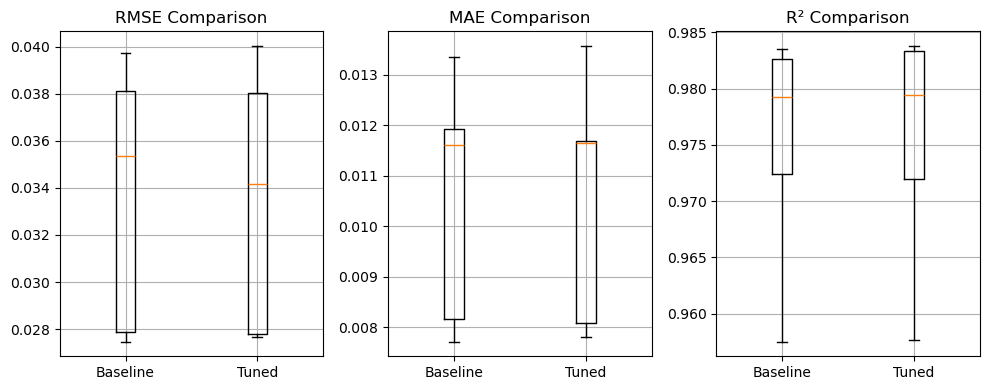

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# RMSE Comparison
plt.subplot(1, 3, 1)
plt.boxplot([rmse_list, rmse_list_tuned], tick_labels=["Baseline", "Tuned"])
plt.title("RMSE Comparison")
plt.grid(True)

# MAE Comparison
plt.subplot(1, 3, 2)
plt.boxplot([mae_list, mae_list_tuned], tick_labels=["Baseline", "Tuned"])
plt.title("MAE Comparison")
plt.grid(True)

# R² Comparison
plt.subplot(1, 3, 3)
plt.boxplot([r2_list, r2_list_tuned], tick_labels=["Baseline", "Tuned"])
plt.title("R² Comparison")
plt.grid(True)

plt.tight_layout()
plt.savefig("rf_baseline_vs_tuned_boxplot.png", dpi=300)
plt.show()


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import numpy as np
import joblib

# Define a wider hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 500, 1000],  # try bigger jumps
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# Use BatteryWiseSplit for cross-validation
splitter = BatteryWiseSplit(n_splits=5, random_state=42)
grid = list(ParameterGrid(param_grid))

best_score = float('inf')
best_model = None
best_params = None

# Iterate over all parameter combinations
for params in grid:
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)  # use all CPU cores
    fold_scores = []

    # Perform 5-fold battery-wise cross-validation
    for train_idx, val_idx in splitter.split(df):
        X_train, X_val = X_imputed[train_idx], X_imputed[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        fold_scores.append(rmse)

    avg_rmse = np.mean(fold_scores)
    print(f"Params: {params} → Avg RMSE: {avg_rmse:.4f}")

    # Save the best model (lowest average RMSE)
    if avg_rmse < best_score:
        best_score = avg_rmse
        best_model = model
        best_params = params

# Save best model to disk
joblib.dump(best_model, "RF_tuned_wide_v4.pkl")
print("\n Best Params:", best_params)


Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100} → Avg RMSE: 0.0337
Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500} → Avg RMSE: 0.0337
Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 1000} → Avg RMSE: 0.0337
Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100} → Avg RMSE: 0.0339
Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 500} → Avg RMSE: 0.0338
Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 1000} → Avg RMSE: 0.0338
Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100} → Avg RMSE: 0.0342
Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 500} → Avg RMSE: 0.0338
Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 1000} → Avg RMSE: 0.0337
Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100} → Avg RMSE: 0.0340
Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 500} → Avg RMSE: 0.

In [20]:
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load the tuned v4 model
tuned_model_v4 = joblib.load("RF_tuned_wide_v4.pkl")

# Prepare empty lists for metrics
rmse_list_tuned_wide, mae_list_tuned_wide, r2_list_tuned_wide = [], [], []

# Perform evaluation using same cross-validation
for train_idx, val_idx in splitter.split(df):
    X_train, X_val = X_imputed[train_idx], X_imputed[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    tuned_model_v4.fit(X_train, y_train)
    y_pred = tuned_model_v4.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    rmse_list_tuned_wide.append(rmse)
    mae_list_tuned_wide.append(mae)
    r2_list_tuned_wide.append(r2)

print(f"Tuned v4 Model → Avg RMSE: {np.mean(rmse_list_tuned_wide):.4f}, "
      f"MAE: {np.mean(mae_list_tuned_wide):.4f}, "
      f"R²: {np.mean(r2_list_tuned_wide):.4f}")


Tuned v4 Model → Avg RMSE: 0.0336, MAE: 0.0106, R²: 0.9751


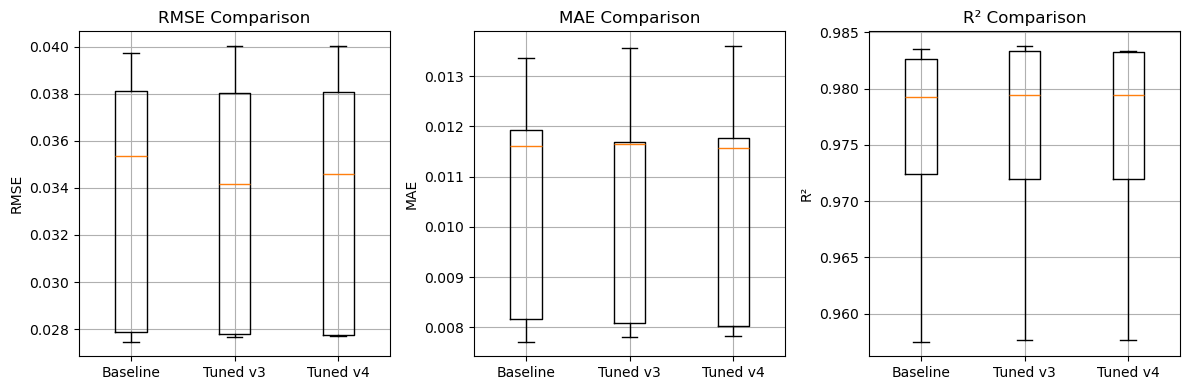

In [21]:
import matplotlib.pyplot as plt

# Lists of metrics from baseline, first tuning, and second (extended) tuning
# Replace these with your actual evaluation result lists
rmse_baseline = rmse_list
mae_baseline = mae_list
r2_baseline = r2_list

rmse_tuned1 = rmse_list_tuned      # from first tuned model (v3)
mae_tuned1 = mae_list_tuned
r2_tuned1 = r2_list_tuned

rmse_tuned2 = rmse_list_tuned_wide  # from second tuned model (v4)
mae_tuned2 = mae_list_tuned_wide
r2_tuned2 = r2_list_tuned_wide

# Create boxplots to compare model performance
plt.figure(figsize=(12, 4))

# RMSE Comparison
plt.subplot(1, 3, 1)
plt.boxplot([rmse_baseline, rmse_tuned1, rmse_tuned2],
            tick_labels=["Baseline", "Tuned v3", "Tuned v4"])
plt.title("RMSE Comparison")
plt.ylabel("RMSE")
plt.grid(True)

# MAE Comparison
plt.subplot(1, 3, 2)
plt.boxplot([mae_baseline, mae_tuned1, mae_tuned2],
            tick_labels=["Baseline", "Tuned v3", "Tuned v4"])
plt.title("MAE Comparison")
plt.ylabel("MAE")
plt.grid(True)

# R² Comparison
plt.subplot(1, 3, 3)
plt.boxplot([r2_baseline, r2_tuned1, r2_tuned2],
            tick_labels=["Baseline", "Tuned v3", "Tuned v4"])
plt.title("R² Comparison")
plt.ylabel("R²")
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.savefig("rf_baseline_vs_tuned_v3_v4_boxplot.png", dpi=300)
plt.show()
